In [2]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *

In [4]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

print(f'zenith_angle_bob_lst: {zenith_angle_bob_lst}')
print(f'zenith_angle_alice_lst: {zenith_angle_alice_lst}')

zenith_angle_bob_lst: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]
zenith_angle_alice_lst: [59.82718274 57.2108359  54.32061774 51.12265988 47.58502771 43.68407524
 39.41624395 34.81936318 30.01091959 25.25726193 21.09107561 18.42093337
 18.23006705 20.60552853 24.62583646 29.3362728  34.15602207 38.79012613
 43.10561986 47.05648663 50.64212895 53.88427991 56.81419115 59.46569665
 61.87164758]


In [ ]:
num_channel_coefficients = 100 #100000

tau_zen_lst = np.array([0.81, 0.75,0.55])
# tau_zen_lst = np.array([0.81])

In [6]:
backend = AerSimulator()

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [ ]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        print(zenith_angle_alice_deg)
        slant_path_alice = slant_path_alice_lst[jdx] # アリスの距離
        sigma_R_squared_alice = rytov_variance(
            wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
        w_L_alice = slant_path_alice * theta_rad
        w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

        # ボブ（Repeater）のパラメータ
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        slant_path_bob = slant_path_bob_lst[jdx] # ボブの距離
        sigma_R_squared_bob = rytov_variance(
            wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
        w_L_bob = slant_path_bob * theta_rad
        w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)
        
        # --- 統計的な平均を取るためのループ ---
        total_err_num = 0
        total_sifted_bit_length = 0
        for kdx in range(int(num_channel_coefficients)):
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

            # アリス(User)の瞬時チャネル
            eta_ell_alice = compute_atm_loss(tau_zen, zenith_angle_alice_rad)
            eta_p_alice = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_alice, theta_rad, a, w_Leq_squared_alice, size=1
            )
            I_a_alice = rvs_LN_fading(sigma_R_squared_alice, size=1)
            insta_eta_alice = eta_ell_alice * I_a_alice * eta_p_alice
            
            # insta_qber_alice = qber_loss(
            #     e_0, p_dark, e_pol, p_AP, insta_eta_alice, n_s
            # )[0]
            # アリスの個別のYieldを計算
            # insta_yield_alice = compute_yield(
            #     insta_eta_alice, n_s, p_dark, p_AP
            # )[0]

            # ボブ(Repeater)の瞬時チャネル
            eta_ell_bob = compute_atm_loss(tau_zen, zenith_angle_bob_rad)
            eta_p_bob = rvs_pointing_err(
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                slant_path_bob, theta_rad, a, w_Leq_squared_bob, size=1
            )
            I_a_bob = rvs_LN_fading(sigma_R_squared_bob, size=1)
            insta_eta_bob = eta_ell_bob * I_a_bob * eta_p_bob
            
            # insta_qber_bob = qber_loss(
            #     e_0, p_dark, e_pol, p_AP, insta_eta_bob, n_s
            # )[0]
            # ボブの個別のYieldを計算
            # insta_yield_bob = compute_yield(
            #     inst a_eta_bob, n_s, p_dark, p_AP
            # )[0]

            # --- ステップ2: 同時検出確率を計算 ---
            p0 = photon_number_probability(0, lambda_signal)
            p1 = photon_number_probability(1, lambda_signal)
            p2 = 1.0 - p0 - p1  # 残りの確率を補完的に計算     
            photon_list = np.random.choice([0, 1, 2], size=10**6, p=[p0, p1, p2])
            unique, counts = np.unique(photon_list, return_counts=True)
            photon_counts = dict(zip(unique, counts))
            # ここまでOK
        
            # photon_counts のキーを int に変換してアクセス
            num_detected_event = 0
            count_0 = int(photon_counts.get(np.int64(0), 0))
            count_1 = int(photon_counts.get(np.int64(1), 0))
            count_2 = int(photon_counts.get(np.int64(2), 0))
            
            part_ka = []
            part_kb = []
            err_num = 0
            total_err_num = 0
            # print(f'insta_eta_alice: {insta_eta_alice}, insta_eta_bob: {insta_eta_bob}')
            # i が 0(photon_counts[0])の時
            num_detected_event = 0
            print(f'Count 0: {count_0}')
            for _ in range(count_0):
                yield_val = yield_from_photon_number(list(photon_counts.keys())[0], Y0_A, Y0_B, insta_eta_alice, insta_eta_bob)
                # print(f'Yield value: {yield_val}')
                # print(yield_alice)
                # print(yield_bob)
                if np.random.rand() < yield_val:
                    num_detected_event += 1
            
            # パウリゲート適用確率を計算
            alice_pauli_probability, bob_pauli_probability = pauli_x_error_probability(list(photon_counts.keys())[0], e_0, p_dark, e_pol, insta_eta_alice, insta_eta_bob)
            print(f'No. Detected event: {num_detected_event}')
            if (num_detected_event % 2 != 0):
                num_detected_event  = num_detected_event - 1
            
            
            # 量子鍵生成(シングルフォトンの場合)
            if (num_detected_event != 0):
                part_ka, part_kb, err_num = generate_Siftedkey(
                    num_detected_event,
                    float(alice_pauli_probability),
                    float(bob_pauli_probability),
                    backend
                )
                
                total_err_num += err_num
                total_sifted_bit_length += len(part_ka)         
            
            
            # i が 1(photon_counts[1])の時
            num_detected_event = 0
            print(f'Count 1: {count_1}')
            for _ in range(count_1):
                yield_val = yield_from_photon_number(list(photon_counts.keys())[1], Y0_A, Y0_B, insta_eta_alice, insta_eta_bob)
                # print(f'Yield value: {yield_val}')
                # print(yield_alice)
                # print(yield_bob)
                if np.random.rand() < yield_val:
                    num_detected_event += 1
            
            # パウリゲート適用確率を計算
            alice_pauli_probability, bob_pauli_probability = pauli_x_error_probability(list(photon_counts.keys())[1], e_0, p_dark, e_pol, insta_eta_alice, insta_eta_bob)
            print(f'No. Detected event: {num_detected_event}')
            if (num_detected_event % 2 != 0):
                num_detected_event  = num_detected_event - 1
            
            
            # 量子鍵生成(シングルフォトンの場合)
            if (num_detected_event != 0):
                part_ka, part_kb, err_num = generate_Siftedkey(
                    num_detected_event,
                    float(alice_pauli_probability),
                    float(bob_pauli_probability),
                    backend
                )
                
                total_err_num += err_num
                total_sifted_bit_length += len(part_ka)         
            
            
            # i が 2(photon_counts[2])の時
            num_detected_event = 0
            for _ in range(count_2):
                yield_val = yield_from_photon_number(list(photon_counts.keys())[2], Y0_A, Y0_B, insta_eta_alice, insta_eta_bob)
                # print(yield_alice)
                # print(yield_bob)
                # ランダム値と比較して、検出される確率に応じてカウント
                if np.random.rand() < yield_val:
                    num_detected_event += 1
            
            # パウリゲート適用確率を計算
            alice_pauli_probability, bob_pauli_probability = pauli_x_error_probability(list(photon_counts.keys())[2], e_0, p_dark, e_pol, insta_eta_alice, insta_eta_bob)
            print(f'No. Detected event: {num_detected_event}')
            if (num_detected_event % 2 != 0):
                num_detected_event  = num_detected_event - 1
            
            # 量子鍵生成(マルチフォトンの場合)
            if (num_detected_event != 0):
                part_ka, part_kb, err_num = generate_Siftedkey(
                    num_detected_event,
                    float(alice_pauli_probability),
                    float(bob_pauli_probability),
                    backend
                )
                total_err_num += err_num
                total_sifted_bit_length += len(part_ka)
        if total_sifted_bit_length == 0:
            avg_qber = float('nan')
        else:
            avg_qber = total_err_num / total_sifted_bit_length
        qber_simul[idx][jdx] = avg_qber
        print(f'Average QBER: {avg_qber} (tau_zen: {tau_zen}, zenith_angle_alice: {zenith_angle_alice_deg})')
           

59.827182736361635
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 948939
No. Detected event: 0
Count 1: 49112
No. Detected event: 1
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949171
No. Detected event: 0
Count 1: 48954
No. Detected event: 2


/var/folders/tf/49b3fvxj3tv5hbp85s1b7dpw0000gn/T/ipykernel_19456/1209430316.py:136: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(alice_pauli_probability),
/var/folders/tf/49b3fvxj3tv5hbp85s1b7dpw0000gn/T/ipykernel_19456/1209430316.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(bob_pauli_probability),


No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949257
No. Detected event: 0
Count 1: 48795
No. Detected event: 1
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949226
No. Detected event: 0
Count 1: 48829
No. Detected event: 2
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949102
No. Detected event: 0
Count 1: 48984
No. Detected event: 1
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 948792
No. Detected event: 0
Count 1: 49297
No. Detected event: 0
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 948765
No. Detected event: 0
Count 1: 49289
No. Detected event: 1
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949360
No. Detected event: 0

/var/folders/tf/49b3fvxj3tv5hbp85s1b7dpw0000gn/T/ipykernel_19456/1209430316.py:167: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(alice_pauli_probability),
/var/folders/tf/49b3fvxj3tv5hbp85s1b7dpw0000gn/T/ipykernel_19456/1209430316.py:168: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(bob_pauli_probability),


No. Detected event: 0
Count 1: 48785
No. Detected event: 8
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 948750
No. Detected event: 0
Count 1: 49249
No. Detected event: 2
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949277
No. Detected event: 0
Count 1: 48689
No. Detected event: 0
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949067
No. Detected event: 0
Count 1: 48940
No. Detected event: 1
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 949119
No. Detected event: 0
Count 1: 48917
No. Detected event: 0
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 0.0019649683747584926
Count 0: 948696
No. Detected event: 0
Count 1: 49374
No. Detected event: 0
No. Detected event: 0
p0: 0.9490347012165914, p1: 0.049000330408650115, p2: 

KeyboardInterrupt: 

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

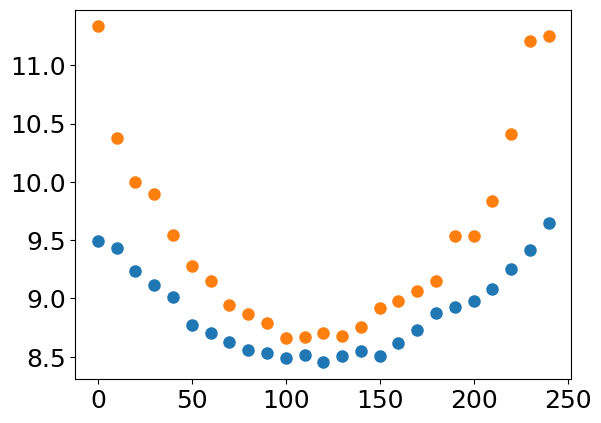

In [11]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)


In [12]:
np.save('results/qber_simul_bbm92_test1_8', qber_simul)

In [13]:
skr_values =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [16]:
# for idx in range(len(tau_zen_lst)):
#     tau_zen = tau_zen_lst[idx]
#     for jdx in range(len(zenith_angle_alice_lst)):
#         zenith_angle_deg = zenith_angle_lst[jdx]
#         zenith_angle_rad = np.radians(zenith_angle_deg)
        
#         w_L = slant_path_lst[jdx] * theta_rad

#         _, yield_values= compute_avg_qber(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )
        

#         Q_1, e_1 = compute_Q_1_e_1_ex(
#             sigma_theta_x, sigma_theta_y, slant_path_lst[jdx], mu_x, mu_y,
#             zenith_angle_rad, h_OGS, h_atm, w_L, tau_zen, Cn2_profile,
#             a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
#         )

#         skr_values[idx][jdx] = compute_SKR(
#             qber_simul[idx][jdx], yield_values, Q_1, e_1
#         )
qber_simul = np.load('results/qber_simul_bbm92_test1_8.npy')
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        
        # --- アリスとボブの平均チャネル性能を計算 ---
        # w_Lをそれぞれ計算
        w_L_alice = slant_path_alice_lst[jdx] * theta_rad
        w_L_bob = slant_path_bob_lst[jdx] * theta_rad

        # アリスの性能
        _, yield_alice = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_alice_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_alice_lst[jdx]), h_OGS, h_atm, w_L_alice, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        
        # ボブの性能
        _, yield_bob = compute_avg_qber(
            sigma_theta_x, sigma_theta_y, slant_path_bob_lst[jdx], mu_x, mu_y,
            np.radians(zenith_angle_bob_lst[jdx]), h_OGS, h_atm, w_L_bob, tau_zen, Cn2_profile,
            a, e_0, p_dark, e_pol, p_AP, n_s, wavelength
        )
        yield_system = yield_alice * yield_bob
        
        skr_values[idx][jdx] = compute_SKR_final(
            qber_system=qber_simul[idx][jdx], # 計算したシステムQBER
            yield_alice=yield_alice,         # 計算したアリスのYield
            yield_bob=yield_bob,           # 計算したボブのYield
            f_ec=1.0,
            rep_rate=1e9
        )

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

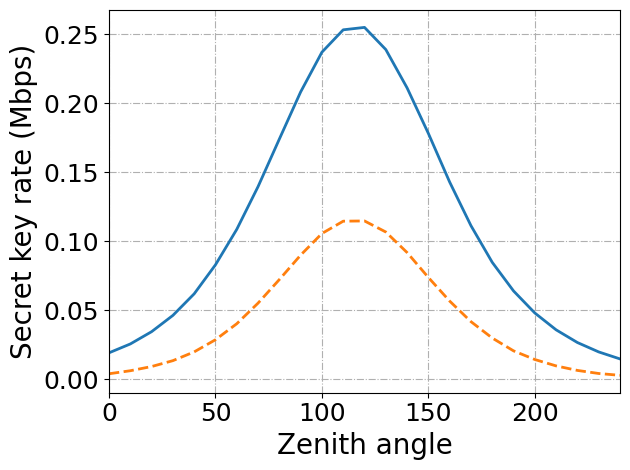

In [17]:
plt.plot(t, skr_values[0][:]/10**6)
plt.plot(t, skr_values[1][:]/10**6, ls='--')


plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [9]:
np.save('results/skr_simul_bbm92_test1', skr_values)